# 1. Pre-process the documents

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# if you do not have 'nltk', the following command should work "python -m pip install nltk"
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import time
import json
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string

1. import the tweets and the doc ids to map them

In [4]:
tweets_path = '/content/drive/Shareddrives/IRWA/IRWA_data_2024/data/farmers-protest-tweets.json'
with open(tweets_path) as fp:
    tweets = fp.readlines()
tweets = [l.strip().replace(' +', ' ') for l in tweets]
for i in range(len(tweets)):
  tweets[i] = json.loads(tweets[i])

In [5]:
docs_path = '/content/drive/Shareddrives/IRWA/IRWA_data_2024/data/tweet_document_ids_map.csv'
with open(docs_path) as fp:
    doc_id = fp.readlines()
doc_id = [l.strip().replace(' +', ' ') for l in doc_id]
for i in range(len(doc_id)):
  doc_id[i]=doc_id[i].split(",")


2. keep the elements we will show the user when they have the query

In [6]:
#Tweet | Date | Hashtags| Likes | Retweets | Url
keys_to_keep=["url", "date", "content", "id", "retweetCount", "likeCount"]
tweets_values_to_keep=[]
for x in tweets:
  new_dict ={k: x[k] for k in x.keys() & keys_to_keep }
  tweets_values_to_keep.append(new_dict)

3. map the tweet id with their equivalent in doc_id and eliminate the ones that don't have one

In [7]:
#map the tweet ids to the doc id
id_to_doc = {row[1]: row[0] for row in doc_id[1:]}

tweets_values_to_keep = [
    tweets_values_to_keep[i] for i in range(len(tweets_values_to_keep))
    if str(tweets_values_to_keep[i]['id']) in id_to_doc  # Keep only if id exists in doc_id
]

for i in range(len(tweets_values_to_keep)):
  tweets_values_to_keep[i]['id'] = id_to_doc.get(str(tweets_values_to_keep[i]['id']), tweets_values_to_keep[i]['id'])

function to eliminate the emojis of the tweets

In [8]:
def remove_emojis(text):

    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251"  # Enclosed characters
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub(r' ', text)  # Replace emojis by an empty string

4. remove mentions/ hashtags/ url and extra spaces from content and separate hashtags as an entry in the dictionary without the symbol #

In [9]:
def preprocess_tweet(tweet_dict):

  for i in range(len(tweet_dict)):
    tweet_content = tweets_values_to_keep[i]['content']

    hashtags = [tag[1:] for tag in re.findall(r'#\w+', tweet_content)]  # Remove the '#' symbol


    cleaned_content = re.sub(r'@\w+', '', tweet_content)  # Remove mentions
    cleaned_content = re.sub(r'#\w+', '', cleaned_content)  # Remove hashtags
    cleaned_content = re.sub(r'http\S+', '', cleaned_content)  # Remove URLs
    cleaned_content = re.sub(r'\s+', ' ', cleaned_content).strip()  # Remove extra spaces
    cleaned_content = remove_emojis(cleaned_content)


    tweet_dict[i]['content'] = cleaned_content
    tweet_dict[i]['hashtags'] = hashtags

  return tweet_dict

In [10]:
tweets_separated_info=preprocess_tweet(tweets_values_to_keep)


In [11]:
def build_terms(line):
    """
    Preprocess the article text (title + body) removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.

    Argument:
    line -- string (text) to be preprocessed

    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    ## START CODE

    line=  line.lower() ## Transform in lowercase
    line = re.sub(r'[{}]'.format(string.punctuation), '', line) # Remove punctuation
    line=  line.split() ## Tokenize the text to get a list of terms
    line=[word for word in line if word not in stop_words]  ##eliminate the stopwords (HINT: use List Comprehension) for each word in line that we have from split, if it's not in stop words we keep it
    line=[stemmer.stem(word) for word in line] ## perform stemming (HINT: use List Comprehension) apply stem to the stemmer for each word in line
    ## END CODE
    return line

5. combine the content and hashtags strings to apply it to build terms with the #

In [12]:
def combine_content_and_hashtags(tweet_dict_list):
    combined_entries = []

    for tweet in tweet_dict_list:
        # Join hashtags into a single string
        hashtags_str = ' '.join(tweet['hashtags'])  # Combine all hashtags into a single space-separated string
        combined_string = tweet['content'] + " " + hashtags_str  # Concatenate content and hashtags
        combined_entries.append(combined_string)  # Add to the list

    return combined_entries


In [13]:
preprocess_tweets=combine_content_and_hashtags(tweets_separated_info)

In [14]:
for i in range(len(preprocess_tweets)):
  preprocess_tweets[i]= build_terms(preprocess_tweets[i])

# 2. Exploratory Data Analysis

1. Word count and top words

In [15]:
def content_words():
  word_counts = Counter()
  for tweet in tweets_separated_info:
    if 'content' in tweet:
      terms = build_terms(tweet['content'])
      word_counts.update(terms)

  return word_counts

content_terms = content_words()
top_10_words = content_terms.most_common(10) # Get the top 10 most frequent words

print("Top 10 most frequent words:")
for word, count in top_10_words:
  print(f"{word}: {count}")

Top 10 most frequent words:
farmer: 15485
india: 6234
support: 5975
protest: 4685
amp: 4256
right: 3555
peopl: 3471
indian: 2897
govern: 2671
modi: 2603


2. Word clouds for the most frequent words

In [28]:
def plot_top_x_words_wordcloud(words, x): #words must be a Counter()

  top_x_words = words.most_common(x)
  word_dict = dict(top_x_words)

  wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(word_dict)

  plt.figure(figsize=(10, 6))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f"Top {x} Word Cloud", fontsize=16)
  plt.show()

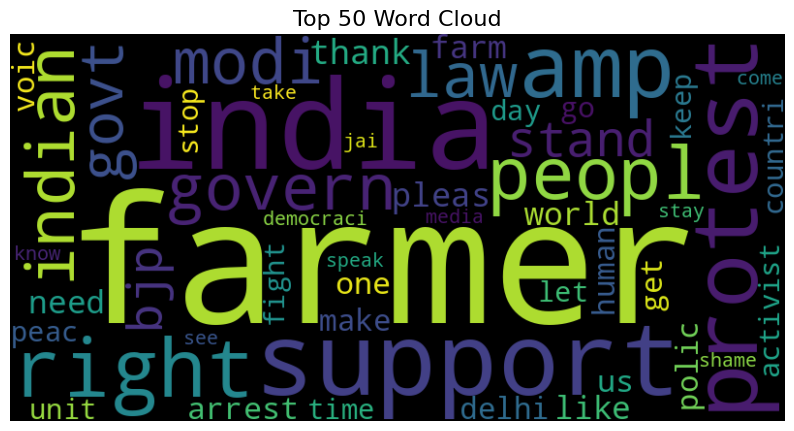

In [29]:
plot_top_x_words_wordcloud(content_terms, 50)

3. Average sentence length

In [20]:
def average_sentence_length_for_tweet(content):

    sentences = re.split(r'[.!?]', content.strip()) #get sentences of tweet

    sentences = [sentence for sentence in sentences if sentence] #with the split we get some empty sentences so we eliminate them to not alterate the average

    total_words = sum(len(sentence.split()) for sentence in sentences) #count words of sentences


    num_sentences = len(sentences)


    avg_sentence_length = total_words / num_sentences if num_sentences > 0 else 0

    return avg_sentence_length

def calculate_avg_sentence_length_for_collection(tweets):
    avg_lengths = {}
    total_length = 0
    total_tweets = len(tweets)

    for tweet in tweets:
        content = tweet['content']
        avg_length = average_sentence_length_for_tweet(content)

        avg_lengths[tweet['id']] = avg_length #store the average length of each doc in a dictionary
        total_length += avg_length #at the same time keep count of the averages to return the total


    overall_avg_length = total_length / total_tweets if total_tweets > 0 else 0

    return avg_lengths, overall_avg_length

In [21]:
avg_lengths, overall_avg_length = calculate_avg_sentence_length_for_collection(tweets_separated_info)

print("Average Sentence Length per Tweet:", avg_lengths)
print(f"Overall Average Sentence Length: {overall_avg_length:.2f} words per sentence")

Average Sentence Length per Tweet: {'doc_0': 13.0, 'doc_1': 5.8, 'doc_2': 4.0, 'doc_3': 4.0, 'doc_4': 4.0, 'doc_5': 15.0, 'doc_6': 7.0, 'doc_7': 3.0, 'doc_8': 10.0, 'doc_9': 5.0, 'doc_10': 3.0, 'doc_11': 3.5, 'doc_12': 9.333333333333334, 'doc_13': 15.0, 'doc_14': 12.0, 'doc_15': 13.666666666666666, 'doc_16': 4.0, 'doc_17': 10.0, 'doc_18': 6.5, 'doc_19': 12.5, 'doc_20': 24.0, 'doc_21': 1.0, 'doc_22': 13.333333333333334, 'doc_23': 3.0, 'doc_24': 15.5, 'doc_25': 14.0, 'doc_26': 15.666666666666666, 'doc_27': 11.0, 'doc_28': 6.0, 'doc_29': 17.0, 'doc_30': 15.0, 'doc_31': 21.0, 'doc_32': 7.8, 'doc_33': 19.0, 'doc_34': 5.0, 'doc_35': 7.0, 'doc_36': 8.2, 'doc_37': 18.0, 'doc_38': 12.5, 'doc_39': 21.0, 'doc_40': 5.0, 'doc_41': 9.0, 'doc_42': 5.0, 'doc_43': 21.0, 'doc_44': 4.0, 'doc_45': 5.0, 'doc_46': 14.0, 'doc_47': 18.5, 'doc_48': 11.0, 'doc_49': 36.0, 'doc_50': 2.0, 'doc_51': 7.0, 'doc_52': 12.0, 'doc_53': 30.0, 'doc_54': 3.0, 'doc_55': 6.5, 'doc_56': 10.333333333333334, 'doc_57': 5.0, 'doc_

4. Top hashtags

In [22]:
def find_top_hashtags(tweet_dict, top_n):
    all_hashtags = []

    for tweet in tweet_dict:
        all_hashtags.extend(tweet['hashtags'])  # Extend list with hashtags from each tweet

    hashtag_counts = Counter(all_hashtags)

    top_hashtags = hashtag_counts.most_common(top_n)

    return top_hashtags

In [23]:
def plot_top_hashtag_wordcloud(top_hashtags):
    hashtag_dict = dict(top_hashtags)

    wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(hashtag_dict)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Top Hashtags Word Cloud", fontsize=16)
    plt.show()

In [24]:
top_hashtags = find_top_hashtags(tweets_values_to_keep, top_n=10)

print("Top Hashtags:")
for hashtag, count in top_hashtags:
    print(f"{hashtag}: {count}")

Top Hashtags:
FarmersProtest: 45856
ReleaseDetainedFarmers: 2430
farmersprotest: 2305
FarmersMakeIndia: 2129
IndiaBeingSilenced: 2128
MahapanchayatRevolution: 1939
DishaRavi: 1914
RepealOnlyWayAhead: 1751
Pagdi_Sambhal_Jatta: 1581
FarmersProtests: 1564


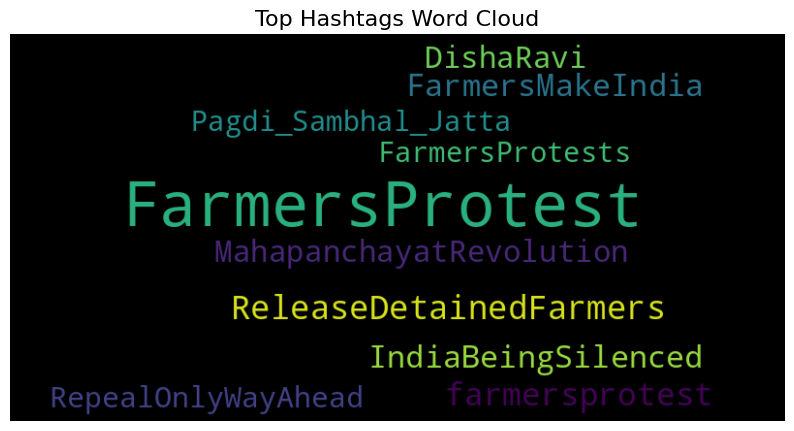

In [25]:
plot_top_hashtag_wordcloud(top_hashtags)

5. Most retweeted/ liked

In [26]:
def get_most_retweeted(tweets, n):
    top_retweeted = sorted(tweets, key=lambda x: x['retweetCount'], reverse=True)[:n]
    return top_retweeted

def get_most_liked(tweets, n):
    most_liked = sorted(tweets, key=lambda x: x['likeCount'], reverse=True)[:n]
    return most_liked

In [27]:
most_retweeted_tweet = get_most_retweeted(tweets_separated_info, 5)
most_liked_tweet = get_most_liked(tweets_separated_info, 5)

print("Top 5 Most Retweeted Tweets:")
for tweet in most_retweeted_tweet:
    print(tweet)

print("\nTop 5 Most Liked Tweets:")
for tweet in most_liked_tweet:
    print(tweet)

Top 5 Most Retweeted Tweets:
{'url': 'https://twitter.com/dhruv_rathee/status/1364148079117615105', 'likeCount': 27888, 'id': 'doc_3203', 'content': "There's a happening in Germany. But the German Govt didn’t block their path with barbed wires, dig highways or label them Anti-National. And neither did the Govt declare it an ‘internal matter’ where others can’t comment. I guess that’s how democracies work.", 'date': '2021-02-23T09:40:21+00:00', 'retweetCount': 6164, 'hashtags': ['FarmersProtest']}
{'url': 'https://twitter.com/rupikaur_/status/1360882069161803779', 'likeCount': 8974, 'id': 'doc_38410', 'content': 'disha ravi, a 21-year-old climate activist, has been arrested by delhi police for sharing a toolkit posted in support of the . disha’s arrest is alarming and the world needs to pay attention.', 'date': '2021-02-14T09:22:23+00:00', 'retweetCount': 4673, 'hashtags': ['farmersprotest', 'freedisharavi']}
{'url': 'https://twitter.com/amaanbali/status/1360908603155050498', 'likeCount